# <a id="top"></a>Intersecting model grids with shapes

_Note: This feature requires the shapely and descartes packages (which are not a FloPy dependency) so must be installed by the user._

This notebook shows the grid intersection functionality in flopy. The intersection methods are available through the GridIntersect object. A flopy modelgrid is passed to instantiate the object. Then the modelgrid can be intersected with Points, LineStrings and Polygons through the different intersection methods. 

There are three intersection modes: 
- the first (default mode) builds an STR-tree for fast spatial queries before calculating intersections, thereby reducing the number of grid cells it has to process. This method works for structured and vertex grids.
- the second method does not construct the STR-tree, and loops through all gridcells to determine the intersection between the grid and the shape. This method also works for structured and vertex grids.
- the third method only works for structured grids and uses information from the structured grid to limit the search space for intersections.

This notebook showcases the functionality of the GridIntersect class. 


### Table of Contents
- [GridIntersect Class](#gridclass)
- [Rectangular regular grid](#rectgrid)
    - [Polygon with regular grid](#rectgrid.1)
    - [MultiLineString with regular grid](#rectgrid.2)
    - [MultiPoint with regular grid](#rectgrid.3)
- [Vertex grid](#trigrid)
    - [Polygon with triangular grid](#trigrid.1)
    - [MultiLineString with triangular grid](#trigrid.2)
    - [MultiPoint with triangular grid](#trigrid.3)

Import some stuff

In [1]:
import sys
import os
import platform
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

sys.path.insert(1, "../..")

# run installed version of flopy or add local path
try:
    import flopy
    import flopy.discretization as fgrid
    import flopy.plot as fplot
    from flopy.utils.gridintersect import GridIntersect
except:
    fpth = os.path.abspath(os.path.join('..', '..'))
    sys.path.append(fpth)
    import flopy
    import flopy.discretization as fgrid
    import flopy.plot as fplot
    from flopy.utils.gridintersect import GridIntersect

import shapely
from shapely.geometry import Polygon, Point, LineString, MultiLineString, MultiPoint, MultiPolygon
from shapely.strtree import STRtree    

print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))

flopy is installed in /home/david/Github/flopy_db/flopy
3.7.6 (default, Jan  8 2020, 19:59:22) 
[GCC 7.3.0]
numpy version: 1.18.1
matplotlib version: 3.1.3
flopy version: 3.3.1


## <a id="gridclass"></a>[GridIntersect Class](#top)

The GridIntersect class is constructed by passing a flopy modelgrid object to the constructor. There are options users can select to change how the intersection is calculated.

- `method`: either `"vertex"` (default) or `"structured"`. If `"structured"` is passed, the intersections are performed using structured methods. These methods use information about the regular grid to limit the search space for intersection calculations. 
- `rtree`: either `True` (default) or `False`, only read when `method="vertex"`. When True, an STR-tree is built, which allows for fast spatial queries. Building the STR-tree does take some time however. Setting the option to False avoids building the STR-tree but requires the intersection calculation to essentially loop through all grid cells.

In general the default option is robust (it always works) and fast and is therefore recommended in most situations. If you are working with a structured grid, then the `method="structured"` can speed up intersection operations (especially for points and linestrings) with the added advantage of not having to build an STR-tree. In some cases with vertex grids, it might not be worth your time building the STR-tree, in which case it can be avoided by passing `rtree=False`.

The important methods in the GridIntersect object are:
- `intersects()`: returns cellids for gridcells that intersect a shape
- `intersect_point()`: for intersecting the modelgrid with point geometries
- `intersect_linestring()`: for intersecting the modelgrid with linestrings
- `intersect_polygon()`: for intersecting the modelgrid with polygons
- `plot_point()`: for plotting point intersection results
- `plot_linestring()`: for plotting linestring intersection results
- `plot_polygon()`: for plotting polygon intersection results

In the following sections examples of intersections are shown for structured and vertex grids for different types of shapes (Polygon, LineString and Point).

## <a id="rectgrid"></a>[Rectangular regular grid](#top)

In [2]:
delc = 10*np.ones(10, dtype=np.float)
delr = 10*np.ones(10, dtype=np.float)

In [3]:
xoff = 0.
yoff = 0.
angrot = 0.
sgr = fgrid.StructuredGrid(delc, delr, top=None, botm=None, xoff=xoff, yoff=yoff, angrot=angrot)

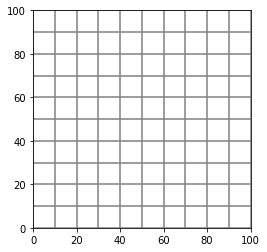

In [4]:
sgr.plot()

### <a id="rectgrid.1"></a>[Polygon with regular grid](#top)
Polygon to intersect with:

In [5]:
p = Polygon(shell=[(15, 15), (20, 50), (35, 80.), (80, 50), 
                   (80, 40), (40, 5), (15, 12)], 
            holes=[[(25, 25), (25, 45), (45, 45), (45, 25)]])

Create the GridIntersect class for our modelgrid. The keyword arguments are shown below, but as these are the default options, they do not need to be passed necesssarily.

In [6]:
ix = GridIntersect(sgr, method="vertex", rtree=True)

Do the intersect operation for a polygon

In [7]:
%timeit ix.intersect_polygon(p)

6.21 ms ± 866 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [8]:
result = ix.intersect_polygon(p)

The results are returned as a numpy.recarray containing several fields based on the intersection performed. An explanation of the data in each of the possible fields is given below:
- **cellids**: contains the cell ids of the intersected grid cells
- **vertices**: contains the vertices of the intersected shape
- **areas**: contains the area of the polygon in that grid cell (only for polygons)
- **lenghts**: contains the length of the linestring in that grid cell (only for linestrings)
- **ixshapes**: contains the shapely object representing the intersected shape (useful for plotting the result)

Looking at the first few entries of the results of the polygon intersection (convert to pandas.DataFrame for prettier formatting)

In [9]:
result[:5]
# pd.DataFrame(result)  # for prettier formatting

rec.array([((2, 3), (((30.0, 70.0), (35.0, 80.0), (40.0, 76.66666666666667), (40.0, 70.0), (30.0, 70.0)),),  66.66666667, <shapely.geometry.polygon.Polygon object at 0x7fea0289fd90>),
           ((2, 4), (((40.0, 76.66666666666667), (50.0, 70.0), (40.0, 70.0), (40.0, 76.66666666666667)),),  33.33333333, <shapely.geometry.polygon.Polygon object at 0x7fea0284d5d0>),
           ((3, 2), (((25.0, 60.0), (30.0, 70.0), (30.0, 60.0), (25.0, 60.0)),),  25.        , <shapely.geometry.polygon.Polygon object at 0x7fea0289f050>),
           ((3, 3), (((30.0, 70.0), (40.0, 70.0), (40.0, 60.0), (30.0, 60.0), (30.0, 70.0)),), 100.        , <shapely.geometry.polygon.Polygon object at 0x7fea0289f890>),
           ((3, 4), (((40.0, 70.0), (50.0, 70.0), (50.0, 60.0), (40.0, 60.0), (40.0, 70.0)),), 100.        , <shapely.geometry.polygon.Polygon object at 0x7fea0289f7d0>)],
          dtype=[('cellids', 'O'), ('vertices', 'O'), ('areas', '<f8'), ('ixshapes', 'O')])

The cellids can be easily obtained 

In [10]:
result.cellids

array([(2, 3), (2, 4), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 2),
       (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (5, 1), (5, 2), (5, 3),
       (5, 4), (5, 5), (5, 6), (5, 7), (6, 1), (6, 2), (6, 4), (6, 5),
       (6, 6), (6, 7), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6),
       (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (9, 2), (9, 3), (9, 4)],
      dtype=object)

Or the areas

In [11]:
result.areas

array([ 66.66666667,  33.33333333,  25.        , 100.        ,
       100.        ,  66.66666667,   8.33333333,  75.        ,
       100.        , 100.        , 100.        ,  91.66666667,
        33.33333333,   7.14285714,  75.        ,  50.        ,
        75.        , 100.        , 100.        , 100.        ,
        21.42857143,  50.        ,  50.        , 100.        ,
        99.10714286,  43.75      ,  35.71428571,  75.        ,
        50.        ,  75.        ,  96.42857143,  32.14285714,
        41.71428571,  99.35714286, 100.        ,  91.96428571,
        22.32142857,   8.64285714,  36.        ,  14.28571429])

If  a user is only interested in which cells the shape intersects (and not the areas or the actual shape of the intersected object) with there is also the `intersects()` method. This method works for all types of shapely geometries.

In [12]:
ix.intersects(p)

rec.array([((9, 4),), ((9, 3),), ((9, 2),), ((8, 1),), ((8, 5),),
           ((8, 4),), ((8, 3),), ((8, 2),), ((7, 6),), ((7, 4),),
           ((7, 2),), ((7, 5),), ((7, 1),), ((7, 3),), ((6, 5),),
           ((6, 8),), ((6, 7),), ((6, 6),), ((6, 4),), ((6, 1),),
           ((6, 2),), ((5, 1),), ((5, 2),), ((5, 3),), ((5, 4),),
           ((5, 5),), ((5, 6),), ((5, 7),), ((5, 8),), ((4, 1),),
           ((4, 2),), ((4, 3),), ((4, 5),), ((4, 6),), ((4, 7),),
           ((4, 8),), ((4, 4),), ((3, 4),), ((3, 6),), ((3, 5),),
           ((3, 3),), ((3, 2),), ((2, 4),), ((2, 2),), ((2, 5),),
           ((2, 3),), ((1, 3),)],
          dtype=[('cellids', 'O')])

The results of an intersection can be visualized with the plotting methods in the `GridIntersect` object:
- `plot_polygon`
- `plot_linestring`
- `plot_point`

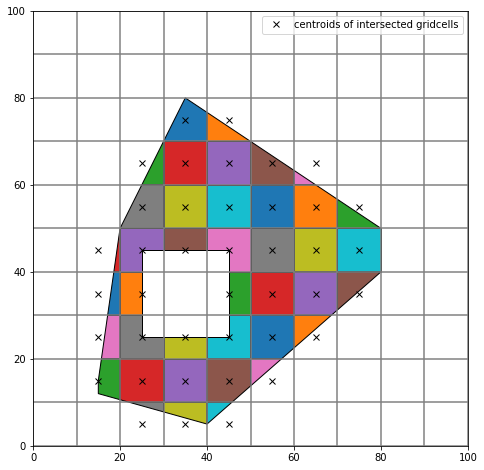

In [13]:
# create a figure and plot the grid
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sgr.plot(ax=ax)

# the intersection object contains some helpful plotting commands
ix.plot_polygon(result, ax=ax)

# add black x at cell centers
for irow, icol in result.cellids:
    h2, = ax.plot(sgr.xcellcenters[0, icol], sgr.ycellcenters[irow, 0], 
                  "kx", label="centroids of intersected gridcells")

# add legend
ax.legend([h2], [i.get_label() for i in [h2]], loc="best");

Alternatively, the intersection can be calculated using special methods optimized for structured grids. Access these methods by instantiating the GridIntersect class with the `method="structured"` keyword argument.

In [14]:
ixs = GridIntersect(sgr, method="structured")

The methods are optimized for structured grids, but for certain types of polygons there is no benefit (as can be seen in this example).

In [15]:
%timeit ixs.intersect_polygon(p)

9.06 ms ± 1.38 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


The result is the same as before:

In [16]:
result2 = ixs.intersect_polygon(p)
result2[:5]

rec.array([((2, 3), (((30.0, 70.0), (35.0, 80.0), (40.0, 76.66666666666667), (40.0, 70.0), (30.0, 70.0)),),  66.66666667, <shapely.geometry.polygon.Polygon object at 0x7fea026a8d10>),
           ((2, 4), (((40.0, 76.66666666666667), (50.0, 70.0), (40.0, 70.0), (40.0, 76.66666666666667)),),  33.33333333, <shapely.geometry.polygon.Polygon object at 0x7fea026a8b10>),
           ((3, 2), (((25.0, 60.0), (30.0, 70.0), (30.0, 60.0), (25.0, 60.0)),),  25.        , <shapely.geometry.polygon.Polygon object at 0x7fea026a86d0>),
           ((3, 3), (((30.0, 70.0), (40.0, 70.0), (40.0, 60.0), (30.0, 60.0), (30.0, 70.0)),), 100.        , <shapely.geometry.polygon.Polygon object at 0x7fea026a8450>),
           ((3, 4), (((40.0, 70.0), (50.0, 70.0), (50.0, 60.0), (40.0, 60.0), (40.0, 70.0)),), 100.        , <shapely.geometry.polygon.Polygon object at 0x7fea026a8550>)],
          dtype=[('cellids', 'O'), ('vertices', 'O'), ('areas', '<f8'), ('ixshapes', 'O')])

### <a id="rectgrid.2"></a>[Polyline with regular grid](#top)
MultiLineString to intersect with:

In [17]:
ls1 = LineString([(95, 105), (30, 50)])
ls2 = LineString([(30, 50), (90, 22)])
ls3 = LineString([(90, 22), (0, 0)])
mls = MultiLineString(lines=[ls1, ls2, ls3])

In [18]:
%timeit ix.intersect_linestring(mls)

4.22 ms ± 706 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [19]:
result = ix.intersect_linestring(mls)

Plot the result

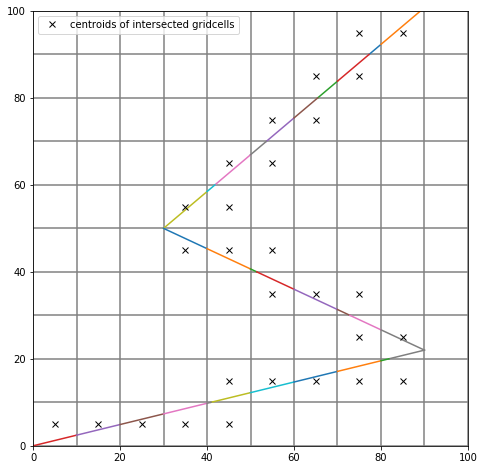

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sgr.plot(ax=ax)
ix.plot_linestring(result, ax=ax)

for irow, icol in result.cellids:
    h2, = ax.plot(sgr.xcellcenters[0, icol], sgr.ycellcenters[irow, 0], "kx", label="centroids of intersected gridcells")
    
ax.legend([h2], [i.get_label() for i in [h2]], loc="best");

Same as before, the intersect for structured grids can also be performed with a different method optimized for structured grids

In [21]:
ixs = GridIntersect(sgr, method="structured")

In [22]:
%timeit ixs.intersect_linestring(mls)

6.42 ms ± 1.17 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


### [MultiPoint with regular grid](#top)<a id="rectgrid.3"></a>

MultiPoint to intersect with

In [23]:
mp = MultiPoint(points=[Point(50.0, 0.0), Point(45., 45.), 
                        Point(10., 10.), Point(150., 100.)])

In [24]:
%timeit ix.intersect_point(mp)

1.27 ms ± 212 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [25]:
result = ix.intersect_point(mp)
result

rec.array([((5, 4), ((45.0, 45.0),), <shapely.geometry.point.Point object at 0x7fea02574650>),
           ((8, 0), ((10.0, 10.0),), <shapely.geometry.point.Point object at 0x7fea02574e10>),
           ((9, 4), ((50.0, 0.0),), <shapely.geometry.point.Point object at 0x7fea02574810>)],
          dtype=[('cellids', 'O'), ('vertices', 'O'), ('ixshapes', 'O')])

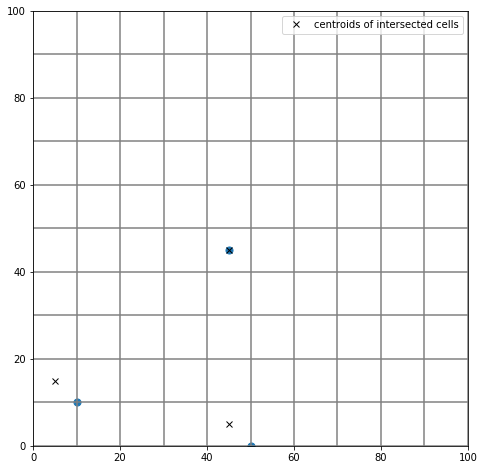

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sgr.plot(ax=ax)
ix.plot_point(result, ax=ax, s=50)
    
for irow, icol in result.cellids:
    h2, = ax.plot(sgr.xcellcenters[0, icol], sgr.ycellcenters[irow, 0], "kx", label="centroids of intersected cells")
    
ax.legend([h2], [i.get_label() for i in [h2]], loc="best");

Same as before, the intersect for structured grids can also be performed with a different method optimized for structured grids

In [27]:
ixs = GridIntersect(sgr, method="structured")

In [28]:
%timeit ixs.intersect_point(mp)

176 µs ± 3.71 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [29]:
ixs.intersect_point(mp)

rec.array([((9, 4), <shapely.geometry.point.Point object at 0x7fea0253c6d0>),
           ((5, 4), <shapely.geometry.point.Point object at 0x7fea0253c890>),
           ((8, 0), <shapely.geometry.point.Point object at 0x7fea0253cbd0>)],
          dtype=[('cellids', 'O'), ('ixshapes', 'O')])

## <a id="trigrid"></a>[Vertex Grid](#top)

In [30]:
cell2d = [[0, 83.33333333333333, 66.66666666666667, 3, 4, 2, 7],
          [1, 16.666666666666668, 33.333333333333336, 3, 4, 0, 5],
          [2, 33.333333333333336, 83.33333333333333, 3, 1, 8, 4],
          [3, 16.666666666666668, 66.66666666666667, 3, 5, 1, 4],
          [4, 33.333333333333336, 16.666666666666668, 3, 6, 0, 4],
          [5, 66.66666666666667, 16.666666666666668, 3, 4, 3, 6],
          [6, 83.33333333333333, 33.333333333333336, 3, 7, 3, 4],
          [7, 66.66666666666667, 83.33333333333333, 3, 8, 2, 4]]
vertices = [[0, 0.0, 0.0],
            [1, 0.0, 100.0],
            [2, 100.0, 100.0],
            [3, 100.0, 0.0],
            [4, 50.0, 50.0],
            [5, 0.0, 50.0],
            [6, 50.0, 0.0],
            [7, 100.0, 50.0],
            [8, 50.0, 100.0]]
tgr = fgrid.VertexGrid(vertices, cell2d)

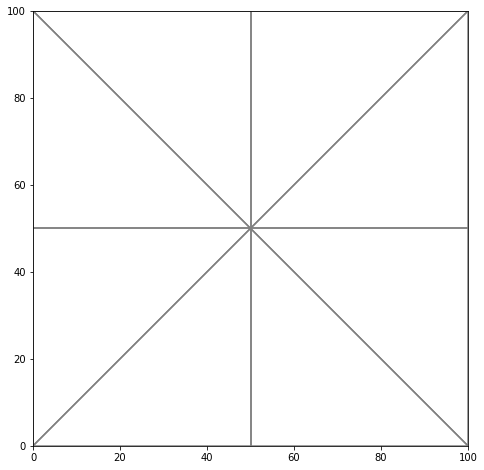

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
pmv = fplot.PlotMapView(modelgrid=tgr)
pmv.plot_grid(ax=ax)

### <a id="trigrid.1"></a>[Polygon with triangular grid](#top)

In [32]:
ix2 = GridIntersect(tgr)

In [33]:
result = ix2.intersect_polygon(p)

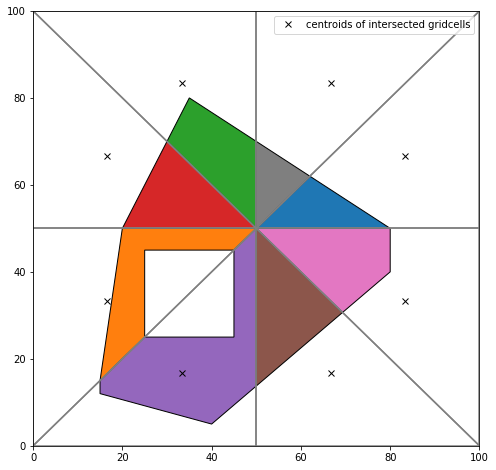

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
pmv = fplot.PlotMapView(ax=ax, modelgrid=tgr)
pmv.plot_grid()
ix.plot_polygon(result, ax=ax)

# only cells that intersect with shape
for cellid in result.cellids:
    h2, = ax.plot(tgr.xcellcenters[cellid], tgr.ycellcenters[cellid], "kx", label="centroids of intersected gridcells")
    
ax.legend([h2], [i.get_label() for i in [h2]], loc="best");

### <a id="trigrid.2"></a>[LineString with triangular grid](#top)

In [35]:
result = ix2.intersect_linestring(mls)

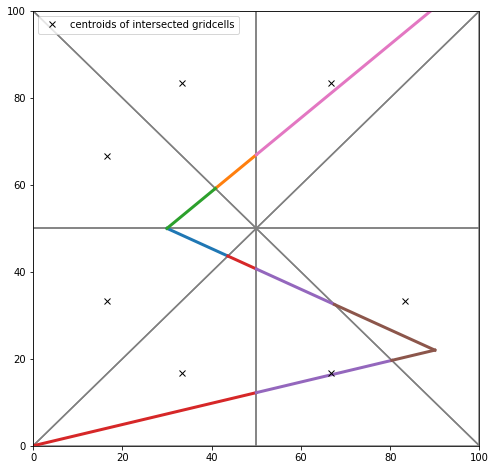

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
pmv = fplot.PlotMapView(ax=ax, modelgrid=tgr)
pmv.plot_grid()
ix2.plot_linestring(result, ax=ax, lw=3)

for cellid in result.cellids:
    h2, = ax.plot(tgr.xcellcenters[cellid], tgr.ycellcenters[cellid], "kx", label="centroids of intersected gridcells")
    
ax.legend([h2], [i.get_label() for i in [h2]], loc="best");

### <a id="trigrid.3"></a>[MultiPoint with triangular grid](#top)

In [37]:
result = ix2.intersect_point(mp)

In [38]:
result

rec.array([(1, ((10.0, 10.0), (45.0, 45.0)), <shapely.geometry.multipoint.MultiPoint object at 0x7fea0231ab90>),
           (4, ((50.0, 0.0),), <shapely.geometry.point.Point object at 0x7fea02326990>)],
          dtype=[('cellids', 'O'), ('vertices', 'O'), ('ixshapes', 'O')])

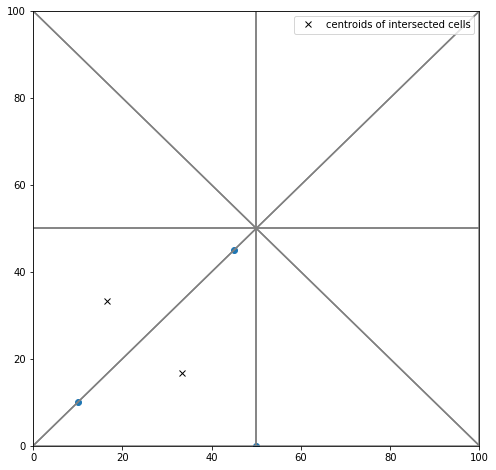

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
pmv = fplot.PlotMapView(ax=ax, modelgrid=tgr)
pmv.plot_grid()
ix2.plot_point(result, ax=ax)
    
for cellid in result.cellids:
    h2, = ax.plot(tgr.xcellcenters[cellid], tgr.ycellcenters[cellid], 
                  "kx", label="centroids of intersected cells")
    
ax.legend([h2], [i.get_label() for i in [h2]], loc="best");